$$\large{\mathbf{Instituto\ Superior\ de\ Engenharia\ de\ Lisboa}}$$

$$\large{\mathrm{Licenciatura\ em\ Engenharia\ Informática\ e\ Multimédia}}$$

$$\Large{\mathbf{Codificação\ de\ Sinais\ Multimédia}}$$

$$\normalsize{\mathbf{3º\ Trabalho\ Prático\\}}$$

# Índice

[**1 - Introdução**](#intro)<br/>
[**2 - Transformação do Espaço de Cor e Subamostragem de Cor**](#subsampling)<br/>
[**3 - Transformada Discreta de Cosseno**](#dct)<br/>
[**4 - Quantização**](#quantization)<br/>
[**5 - Codificação Entrópica**](#encoding)<br/>
[**6 - Taxa de Compressão e *SNR***](#snr)<br/>


In [289]:
import os
import cv2
import sys
import time
import psutil
import humanize
import resource
import traceback
import numpy as np
!pip install GPUtil
import GPUtil as GPU
from pprint import pprint
from enum import Enum, unique
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from google.colab import drive, widgets
from google.colab.patches import cv2_imshow

In [290]:
class Notebook():
    """Holds notebook methods and variables."""
    ROOT = '/content/drive'
    PROJECT = ROOT + '/My Drive/CSM/isel_leim_csm_1819/projects/P03'
    LIBRARY = ROOT + '/My Drive/CSM/isel_leim_csm_1819/projects/lib'
    NOTEBOOK = PROJECT + '/notebooks/'
    RESOURCES = PROJECT + '/resources/raw/'
    REFERENCES = PROJECT + '/references/'
    OUTPUT = PROJECT + '/resources/processed/'
    GPU = GPU.getGPUs()
    PROCESS = psutil.Process(os.getpid())
    
    @classmethod
    def mount(cls):
        """Mounts the (Google) drive in this runtime, all files/folders will be available."""
        drive.mount("/content/drive", force_remount=True)
        for path in [cls.ROOT, cls.PROJECT, cls.LIBRARY, cls.NOTEBOOK, cls.RESOURCES, cls.OUTPUT]:
            try:
                assert os.path.isdir(path), 'Directory not found.'
                sys.path.insert(0, path) #To allow for direct imports
            except AssertionError:
                _, _, tb = sys.exc_info()
                tb_info = traceback.extract_tb(tb)
                filename, line, func, text = tb_info[-1]
                print('An error occurred on line {} in statement {}:'.format(line, text))
                sys.exit(0)
    
    @classmethod
    def memory(cls):
        """Checks the RAM resources available in this runtime, including peak usage stats."""
        print('Gen Available RAM: {} | Process Memory Size: {} | Peak Usage: {} MB'
            .format(
                humanize.naturalsize(psutil.virtual_memory().available), 
                humanize.naturalsize(cls.PROCESS.memory_info().rss),
                resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.))
        for g in cls.GPU:
            print('GPU Available RAM: {0:.1f} GB | Used: {1:.1f} GB | Util {2:0.0f}% | Total {3:.1f} GB'
                .format(
                    g.memoryFree/1000., g.memoryUsed/1000., g.memoryUtil/10., g.memoryTotal/1000.))
    
Notebook.mount()
Notebook.memory()

Mounted at /content/drive
Gen Available RAM: 12.9 GB | Process Memory Size: 546.2 MB | Peak Usage: 542.76 MB
GPU Available RAM: 15.1 GB | Used: 0.0 GB | Util 0% | Total 15.1 GB


In [0]:
@unique
class FileType(Enum):
    """Lists type of input files as an integer."""
    TEXT, IMAGE, SOUND = range(3)

    @classmethod
    def get_name(cls, x) -> enumerate.__name__:
        """Returns type name from its value."""
        return [y for y in cls if x == y.value][0]

    @classmethod
    def get_value(cls, x) -> int:
        """Returns type value from its name."""
        return x.value

    @classmethod
    def get_bit_length(cls) -> int:
        """Checks max bit length needed to represent any file type."""
        return list(cls._value2member_map_)[-1].bit_length()

<a name="intro"></a>
# Introdução
---
O objetivo deste trabalho é apresentar uma implementação do algoritmo de compressão JPEG. Tal formato tem hoje uma presença transversal no armazenamento e transmissão das imagens, e desde o seu lançamento em 1983 é um dos mais eficientes e populares formatos de compressão. Com o processo de digitalização da fotografia, surgiu a necessidade de encontrar uma solução para poder armazenar grandes quantidades de informação, dado que os ficheiros produzidos por formatos *raw* eram demasiado grandes para poderem ser armazenados em volume ou simplesmente para poderem ser usados na *web*. 

O algoritmo de compressão JPEG comprime imagens, reduzindo informação redundante ou informação que devido a limitações do sistema visual humano nunca chega a ser necessária. Os seres humanos são consideravelmente sensíveis a pequenas variações na intensidade de luz, contudo tal precisão não se verifica quando se trata de pequenas variações na cor observada. Isto acontece porque o sistema visual humano é constituído maioritariamente por bastonetes (recetores sensíveis à luminosidade) que por sua vez são aproximadamente mil vezes mais sensíveis à luz do que os cones, recetores de um determinado tipo de comprimento de onda usados para interpretação da cor. 

O algoritmo de compressão JPEG depende desta análise ao sistema visual humano, tratando a cor como informação de menos importância quando comparado à intensidade de luz, neste caso representado numa imagem pela sua representação em tons de cinzento.

A implementação do processo de compressão JPEG será feito utilizando classes em *python* que irão permitir uma melhor modelação e modularização na resolução do problema. Apresenta-se o código integral neste *notebook*, para além de testes e demonstrações de código.

<a name="subsampling"></a>
# Transformação do Espaço de Cores e Subamostragem de Cor
---
O espaço de cores RGB é utilizado com frequência para visualizar e manipular imagens em monitores de computadores, televisores ou dispositivos digitais em geral. É composto por três canais distintos, vermelho (R), verde (G) e azul (B), onde cada canal terá um valor inteiro associado entre 0 e 255. Assim a cor final será a mistura entre as três cores primárias em quantidades determinadas.

Dado que o sistema visual humano é mais sensível às variações de intensidade da luz do que a variações no espectro da luz visivel, pequenas variações de cor podem ser impercetíveis ao olho humano. O estudo dos diferentes órgãos sensoriais humanos permitiu optimizar algoritmos de compressão que adaptam o nível de informação considerado redundante ou dispensável ao grau de acuidade com que esta informação é percepcionada. No caso da visão  e da audição, tal permitiu estabelecer populares algoritmos de compressão que deram origem a formatos populares de armazenamento e transmissão de informação (JPEG, MP3, entre outros).

O primeiro passo da compressão de uma imagem usando o algoritmo JPEG, é transformar o espaço de cores da imagem de maneira a que se consiga extrair a informação da luminosidade para um componente separado dos componentes de cor, permitindo optimizar de forma diferente a luminância e a crominância. O espaço de cores que permite esta separação é designado por *YCbCr* e separa o componente de luminosidade Y (*luma*) dos componentes de cor Cb e Cr (*chroma*), constituídos pela diferença entre os componentes de cor azul e vermelho, respetivamente.

É possível observar que os componentes de cor não apresentam grande variação na distribuição das cores que os constituem sendo possível por isso reduzir significativamente a gama de cores contida nos componentes usando uma técnica designada por *chroma subsampling* que consiste em mapear o valor de um pixel para os pixéis na sua vizinhança, reduzindo assim a gama de cores em 50% ou mais dependendo do rácio usado. No presente trabalho serão implementados os rácios 4:2:2 e 4:2:0, sendo estes os standards mais populares na compressão de imagem da maioria dos dispostivos de gravação.

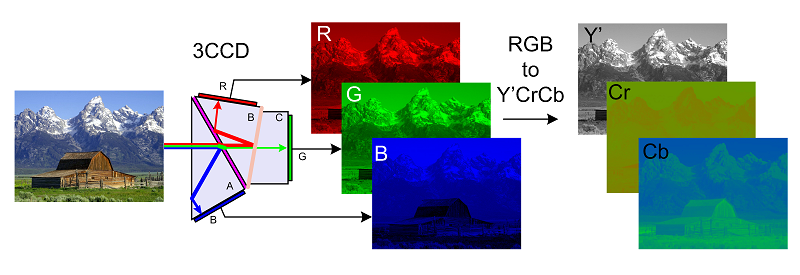

In [292]:
#@title  Transformação do Espaço de Cores (esquema)
path = 'JPEG_ycrcb.png'
assert os.path.isfile(Notebook.REFERENCES + path)
cv2_imshow(cv2.imread(Notebook.REFERENCES + path))  

In [293]:
#@title Subamostragem de Cor (demonstração)
chroma = (4, 2, 2) #@param ['(4, 2, 2)', '(4, 2, 0)'] {type:"raw"}
def sub_sample(matrix: np.ndarray, chroma_type: tuple) -> np.ndarray:
    """Returns a chroma layer subsample of given matrix."""
    if chroma_type == (4, 2, 2):
        return matrix[:,::2]
    elif chroma_type == (4, 2, 0):
        return matrix[:,::2,::2]

print('\n[INFO] Bloco de Imagem (8 x 8)')
blocks = np.array([np.zeros((8,8), dtype=np.uint8)])
blocks[:,:,:4] = 50
pprint(blocks)
print('\n[INFO] Subamostragem de Cor ' + str(chroma))
pprint(sub_sample(blocks, chroma))


[INFO] Bloco de Imagem (8 x 8)
array([[[50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0]]], dtype=uint8)

[INFO] Subamostragem de Cor (4, 2, 2)
array([[[50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0],
        [50, 50, 50, 50,  0,  0,  0,  0]]], dtype=uint8)


<a name="dct"></a>
# Transformada Discreta de Cosseno
---
Após a transformação do espaço de cor da imagem, observa-se que as componentes que constituem a imagem têm blocos de cor que estão bastante correlacionados, sendo essa correlação mais notória quando se observa pequenos blocos de 8x8. Como é sabido o ser humano não consegue distinguir pequenas diferenças na cor, portanto quando esta varia a altas frequências essas cores são percepcionadas pelo nosso cérebro como apenas uma.

A transformada DCT vai extrapolar a informação contida no bloco 8x8 do domínio do espaço para o domínio da frequência, para assim optimizar a imagem às limitações perceptivas do sistema visual humano. A matriz que resulta da transformação DCT pode ser facilmente compreendida de forma análoga a um som que é constituído por uma frequência fundamental e diversas frequências harmónicas, ou como a corrente direta (DC) e corrente alternada (AC) de um sinal elétrico. 

No canto superior esquerdo, o primeiro elemento obtido é a cor fundamental do bloco e que será designado de componente DC, os outros valores do bloco representam a variação respetiva da cor fundamental, estes valores vão ser designados de coeficientes AC e serão usados na função inversa para reconstruir o bloco com um determinado padrão oscilatório de variação (equivalente à soma de sinais cosseno com diferentes frequências). Na essência, a matriz resultante de coeficientes AC e DC corresponde aos fatores de peso que cada padrão oscilatório tem no bloco original. Podemos observar, que os elementos do canto superior esquerdo têm valores mais elevados do que o canto inferior direito, isto acontece porque à medida que fazemos zoom numa imagem há uma grande probabilidade dos pixéis não apresentarem uma grande variação na cor quando comparados com os seus vizinhos. Estes coeficientes representam sob a forma de cossenos discretos a combinação única de amplitudes de luz e cor contida no bloco original.

Contudo, aplicar apenas a DCT constitui apenas um passo para a compressão ideal do bloco original. Para tal, e mais uma vez tirando partido das limitações do sistema visual humano nas diferenças de cor quando estas se apresentam a altas frequências, é usado um processo quantificação que vai eliminar a maior parte dos padrões de alta frequência, isto é, os fatores que se apresentam no canto inferior direito do bloco.

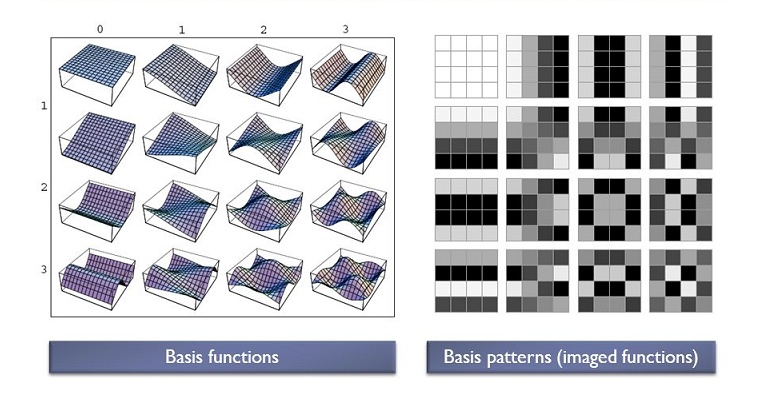

In [0]:
#@title  Transformada Discreta de Cosseno (ilustração)
path = 'JPEG_dct.png'
assert os.path.isfile(Notebook.REFERENCES + path)
cv2_imshow(cv2.imread(Notebook.REFERENCES + path))  

In [294]:
#@title Transformada Discreta de Cosseno (demonstração)
def dct_convert(blocks: np.ndarray) -> np.ndarray:  
    return (np.array([dct(dct(block.transpose(), norm='ortho').astype(np.int16).transpose(), norm='ortho').astype(np.int16) for block in blocks]))

print('\n[INFO] Bloco de Imagem (8 x 8)')
blocks = np.array([np.zeros((8,8), dtype=np.uint8)])
blocks[:,:4,:] = 50
pprint(blocks)
print('\n[INFO] Transformada Discreta de Cosseno')
pprint(dct_convert(blocks))
print('\n')



[INFO] Bloco de Imagem (8 x 8)
array([[[50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [50, 50, 50, 50, 50, 50, 50, 50],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]]], dtype=uint8)

[INFO] Transformada Discreta de Cosseno
array([[[197,   0,   0,   0,   0,   0,   0,   0],
        [181,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [-62,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [ 42,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [-33,   0,   0,   0,   0,   0,   0,   0]]], dtype=int16)




<a name="quantization"></a>
# Quantização
---

Devido à optimização para o sistema visual humano, e com base na transposição da imagem para o domínio da frequência, é possível então remover os componentes AC que correspondem às frequências mais altas, uma vez que essas variações podem ser processadas com menos acuidade. Tal processo é conseguido usando uma tabela de quantização de *standard* JPEG, para reduzir a gama dinâmica dos valores contidos no bloco, tendo mais impacto no canto inferior direito da matriz, onde se encontram os coeficientes de alta frequência. Dividindo os valores da tabela de quantização pelos valores do bloco arredondando ao inteiro mais próximo, obtém-se um bloco cujos valores predominantes são os fatores das baixas frequências.

É neste ponto do algoritmo de compressão JPEG em que acontece a perda de informação, pois uma vez que o valor é arredondado para o inteiro mais próximo, não é possível reverter para os valores originais. Isto não irá constituir um problema pois a diferença entre os valores originais e os valores descodificados será muito reduzida, sendo possível reduzir ainda mais essa diferença se multiplicarmos a matriz de quantificação por um fator de escala. Por outro lado, é também possível neste momento, de acordo com o nível máximo  de qualidade de compressão (JPEG100) obter uma compressão totalmente *lossless*, mantendo ainda um grau de compressão relativamente alto em comparação com o tamanho do ficheiro original.

In [295]:
#@title Quantização (demonstração)
def table_quantize(blocks: np.ndarray, table: np.ndarray, factor: float) -> np.ndarray:
    if factor == 0:
        return np.array([block for block in blocks]).astype(np.int16)
    else:
        return np.array([np.round(block/(table*factor)) for block in blocks]).astype(np.int16) 
def set_quality_factor(quality) -> float:
    if(quality <= 50):
        return 50.0 / quality
    else:
        return 2.0 - (quality * 2.0)/100.0
def table_dequantize(blocks: np.ndarray, table: np.ndarray, factor: float) -> np.ndarray:
    if factor == 0:
        return np.array([block for block in blocks]).astype(np.int16)
    else:
        return np.array([block*(table*factor) for block in blocks]).astype(np.int16)

quality = 50
quality_factor = set_quality_factor(quality)
print('\n[INFO] Bloco de Transformada Discreta de Cosseno')
blocks = np.array([[[197,   0,   0,   0,   0,   0,   0,   0],
                    [181,   0,   0,   0,   0,   0,   0,   0],
                    [  0,   0,   0,   0,   0,   0,   0,   0],
                    [-62,   0,   0,   0,   0,   0,   0,   0],
                    [  0,   0,   0,   0,   0,   0,   0,   0],
                    [ 42,   0,   0,   0,   0,   0,   0,   0],
                    [  0,   0,   0,   0,   0,   0,   0,   0],
                    [-33,   0,   0,   0,   0,   0,   0,   0]]], dtype=np.int16)
pprint(blocks)
K1 = np.array([
                    [  17,  18,  24,  47,  99,  99,  99,  99],
                    [  18,  21,  26,  66,  99,  99,  99,  99],
                    [  24,  26,  56,  99,  99,  99,  99,  99],
                    [  47,  66,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                  ])
#print('\nBloco de Quantização JPEG (Luminância)')
#pprint(K1)
print('\n[INFO] Quantização de Bloco')
quantized = table_quantize(blocks, K1, quality_factor)
pprint(quantized)
print('\n[INFO] Quantização Inversa')
pprint(table_dequantize(quantized, K1, quality_factor))



[INFO] Bloco de Transformada Discreta de Cosseno
array([[[197,   0,   0,   0,   0,   0,   0,   0],
        [181,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [-62,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [ 42,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [-33,   0,   0,   0,   0,   0,   0,   0]]], dtype=int16)

[INFO] Quantização de Bloco
array([[[12,  0,  0,  0,  0,  0,  0,  0],
        [10,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]]], dtype=int16)

[INFO] Quantização Inversa
array([[[204,   0,   0,   0,   0,   0,   0,   0],
        [180,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0

<a name="encoding"></a>
# Codificação Entrópica
---

Como é possível observar, a maior parte dos valores dos blocos quantizados é zero e por isso a imagem processada contém muita informação redundante que pode ser compactada de modo a melhorar a taxa de compressão.

Dado que os blocos quantizados contêm dois tipos de informação distintos, o componente DC e os componentes AC, estes serão tratados de maneira diferente. Os componentes DC são valores relativamente altos e ao comparar blocos adjacentes conclui-se que os valores de DC não variam muito de bloco para bloco. Por essa razão ao invés de enviar os valores na sua totalidade, aplica-se uma codificação DPCM guardando apenas o valor da componente DC do primeiro bloco e posteriormente para os blocos seguintes, a diferença entre o bloco atual e o bloco anterior, reduzindo significativamente a gama dinâmica de valores a serem guardados. A escrita dos bits no *bitstream* será feita usando uma tabela que indica quantos bits terão de ser lidos de modo a obter o valor codificado correto.

Os componentes AC vão sofrer uma compressão mais drástica, isto porque a maior parte dos componentes AC contidos no bloco têm valor zero o que permite aplicar com eficácia uma codificação do tipo RLC, agrupando os componentes AC a zero e reduzindo assim de modo substancial o número de bits necessários para guardar a informação. Os componentes AC, ou seja, os valores *non zero value*, serão codificados do mesmo modo que os componentes DC usando a tabela de *{size, amplitude}*. Para garantir que se agrupam o maior número de zeros, os componentes AC serão codificados em *zig-zag*, garantindo que os valores do canto superior esquerdo (componentes de baixas frequências) são codificados primeiro deixando para o fim os componentes AC a zero que podem ser facilmente agrupados garantindo uma compressão ótima.

In [0]:
from abc import ABC, abstractmethod

class JPEG(ABC):
    """Abstract class parenting JPEG encoding/decoding configurations."""
    
    @abstractmethod
    def __init__(self, 
                 quality: float = 50,
                 chroma_sampling: bool = True,
                 chroma_type: tuple = (4, 2, 0),
                 block_shape: tuple = (8, 8)) -> None:
        assert quality > 0, 'Error. Quality should be gratter than 0.'
        self.__quality = quality
        self.__chroma_sampling = chroma_sampling
        self.__chroma_type = chroma_type
        self.__block_shape = block_shape
        self.__quality_factor = self.set_quality_factor()
    
    def set_quality_factor(self) -> float:
        if(self.quality <= 50):
            return 50.0 / self.quality
        else:
            return 2.0 - (self.quality * 2.0)/100.0
    
    @property
    def quality_factor(self) -> float:
        """Returns the preset quality factor."""
        return self.__quality_factor
    
    @property
    def quality(self) -> float:
        """Returns the preset quality."""
        return self.__quality
    
    @property
    def block_shape(self) -> tuple:
        """Returns the preset block shape."""
        return self.__block_shape

    @property
    def chroma_sampling(self) -> bool:
        """Returns the preset chroma sampling."""
        return self.__chroma_sampling
           
    @property
    def chroma_type(self) -> tuple:
        """Returns the preset chroma type."""
        return self.__chroma_type
    
    @quality.setter
    def quality(self, quality: float) -> None:
        """Resets the quality factor."""
        self.__quality = quality
        
    @block_shape.setter
    def block_shape(self, block_shape: tuple) -> None:
        """Resets the block_shape."""
        self.__block_shape = block_shape
    
    @chroma_sampling.setter
    def chroma_sampling(self, chroma_sampling: bool) -> None:
        """Resets the chroma sampling."""
        self.__chroma_sampling = chroma_sampling
        
    @chroma_type.setter
    def chroma_type(self, chroma_type: tuple) -> None:
        """Resets the chroma type."""
        self.__chroma_type = chroma_type
        
    @staticmethod
    def check_errors(original: np.ndarray, transformed: np.ndarray) -> bool:
        """Compares two arrays."""
        return np.array_equal(original, transformed)

    @staticmethod
    def compression_rate(original_file: str, compressed_file: np.ndarray) -> (float, float, float):
        """Returns a ratio between two file sizes."""
        ini_size = os.path.getsize(original_file)
        end_size = os.path.getsize(compressed_file)
        return round(ini_size / 1000., 3), round(end_size / 1000., 3), round(1 - end_size / ini_size, 2)
    
    @staticmethod
    def calculateSNR(original_image: np.ndarray, compressed_image: np.ndarray) -> np.float64:
        """Returns the SNR between two signals/images."""
        signal = np.sum(np.power(compressed_image, 2))
        noise = np.sum(np.power((original_image-compressed_image), 2))
        return 10*np.log10(signal/noise)

    LUMINANCE = (0,)
    
    CHROMINANCE = (1, 2)
    
    EOB = '1010'
     
    ############## Luminance Quantization Table ##############
    K1 = np.array([
                    [  17,  18,  24,  47,  99,  99,  99,  99],
                    [  18,  21,  26,  66,  99,  99,  99,  99],
                    [  24,  26,  56,  99,  99,  99,  99,  99],
                    [  47,  66,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                    [  99,  99,  99,  99,  99,  99,  99,  99],
                  ])
    
    ############## Chrominance Quantization Table ##############
    K2 = np.array([
                    [  16,  11,  10,  16,  24,  40,  51,  61 ],
                    [  12,  12,  14,  19,  26,  58,  60,  55 ],
                    [  14,  13,  16,  24,  40,  57,  69,  56 ],
                    [  14,  17,  22,  29,  51,  87,  80,  62 ],
                    [  18,  22,  37,  56,  68, 109, 103,  77 ],
                    [  24,  35,  55,  64,  81, 104, 113,  92 ],
                    [  49,  64,  78,  87, 103, 121, 120, 101 ],
                    [  72,  92,  95,  98, 112, 100, 103,  99 ]
                  ])
    
    ############## DC Coefficients Encoding Table ##############
    K3 = {
            0:  '00',
            1:  '010',
            2:  '011',
            3:  '100',
            4:  '101',
            5:  '110',
            6:  '1110',
            7:  '11110',
            8:  '111110',
            9:  '1111110',
            10: '11111110',
            11: '111111110',
            12: '1111111110',
            13: '11111111110',
            14: '111111111110',
            15: '1111111111110',
            16: '11111111111110',
          }
    
    ############## Zig-Zag Index Table ##############
    K4 = np.array([
                    [ 0,  1,  5,  6, 14, 15, 27, 28],
                    [ 2,  4,  7, 13, 16, 26, 29, 42],
                    [ 3,  8, 12, 17, 25, 30, 41, 43],
                    [ 9, 11, 18, 24, 31, 40, 44, 53],
                    [10, 19, 23, 32, 39, 45, 52, 54],
                    [20, 22, 33, 38, 46, 51, 55, 60],
                    [21, 34, 37, 47, 50, 56, 59, 61],
                    [35, 36, 48, 49, 57, 58, 62, 63],
                  ])
    
    ############## AC Coefficients Encoding Table ##############
    K5 = {
            (0, 0):   '1010',
            (0, 1):   '00',
            (0, 2):   '01',
            (0, 3):   '100',
            (0, 4):   '1011',
            (0, 5):   '11010',
            (0, 6):   '1111000',
            (0, 7):   '11111000',
            (0, 8):   '1111110110',
            (0, 9):   '1111111110000010',
            (0, 10):  '1111111110000011',
            (1, 1):   '1100',
            (1, 2):   '11011',
            (1, 3):   '1111001',
            (1, 4):   '111110110',
            (1, 5):   '11111110110',
            (1, 6):   '1111111110000100',
            (1, 7):   '1111111110000101',
            (1, 8):   '1111111110000110',
            (1, 9):   '1111111110000111',
            (1, 10):  '1111111110001000',
            (2, 1):   '11100',
            (2, 2):   '11111001',
            (2, 3):   '1111110111',
            (2, 4):   '111111110100',
            (2, 5):   '1111111110001001',
            (2, 6):   '1111111110001010',
            (2, 7):   '1111111110001011',
            (2, 8):   '1111111110001100',
            (2, 9):   '1111111110001101',
            (2, 10):  '1111111110001110',
            (3, 1):   '111010',
            (3, 2):   '111110111',
            (3, 3):   '111111110101',
            (3, 4):   '1111111110001111',
            (3, 5):   '1111111110010000',
            (3, 6):   '1111111110010001',
            (3, 7):   '1111111110010010',
            (3, 8):   '1111111110010011',
            (3, 9):   '1111111110010100',
            (3, 10):  '1111111110010101',
            (4, 1):   '111011',
            (4, 2):   '1111111000',
            (4, 3):   '1111111110010110',
            (4, 4):   '1111111110010111',
            (4, 5):   '1111111110011000',
            (4, 6):   '1111111110011001',
            (4, 7):   '1111111110011010',
            (4, 8):   '1111111110011011',
            (4, 9):   '1111111110011100',
            (4, 10):  '1111111110011101',
            (5, 1):   '1111010',
            (5, 2):   '11111110111',
            (5, 3):   '1111111110011110',
            (5, 4):   '1111111110011111',
            (5, 5):   '1111111110100000',
            (5, 6):   '1111111110100001',
            (5, 7):   '1111111110100010',
            (5, 8):   '1111111110100011',
            (5, 9):   '1111111110100100',
            (5, 10):  '1111111110100101',
            (6, 1):   '1111011',
            (6, 2):   '111111110110',
            (6, 3):   '1111111110100110',
            (6, 4):   '1111111110100111',
            (6, 5):   '1111111110101000',
            (6, 6):   '1111111110101001',
            (6, 7):   '1111111110101010',
            (6, 8):   '1111111110101011',
            (6, 9):   '1111111110101100',
            (6, 10):  '1111111110101101',
            (7, 1):   '11111010',
            (7, 2):   '111111110111',
            (7, 3):   '1111111110101110',
            (7, 4):   '1111111110101111',
            (7, 5):   '1111111110110000',
            (7, 6):   '1111111110110001',
            (7, 7):   '1111111110110010',
            (7, 8):   '1111111110110011',
            (7, 9):   '1111111110110100',
            (7, 10):  '1111111110110101',
            (8, 1):   '111111000',
            (8, 2):   '111111111000000',
            (8, 3):   '1111111110110110',
            (8, 4):   '1111111110110111',
            (8, 5):   '1111111110111000',
            (8, 6):   '1111111110111001',
            (8, 7):   '1111111110111010',
            (8, 8):   '1111111110111011',
            (8, 9):   '1111111110111100',
            (8, 10):  '1111111110111101',
            (9, 1):   '111111001',
            (9, 2):   '1111111110111110',
            (9, 3):   '1111111110111111',
            (9, 4):   '1111111111000000',
            (9, 5):   '1111111111000001',
            (9, 6):   '1111111111000010',
            (9, 7):   '1111111111000011',
            (9, 8):   '1111111111000100',
            (9, 9):   '1111111111000101',
            (9, 10):  '1111111111000110',
            (10, 1):  '111111010',
            (10, 2):  '1111111111000111',
            (10, 3):  '1111111111001000',
            (10, 4):  '1111111111001001',
            (10, 5):  '1111111111001010',
            (10, 6):  '1111111111001011',
            (10, 7):  '1111111111001100',
            (10, 8):  '1111111111001101',
            (10, 9):  '1111111111001110',
            (10, 10): '1111111111001111',
            (11, 1):  '1111111001',
            (11, 2):  '1111111111010000',
            (11, 3):  '1111111111010001',
            (11, 4):  '1111111111010010',
            (11, 5):  '1111111111010011',
            (11, 6):  '1111111111010100',
            (11, 7):  '1111111111010101',
            (11, 8):  '1111111111010110',
            (11, 9):  '1111111111010111',
            (11, 10): '1111111111011000',
            (12, 1):  '1111111010',
            (12, 2):  '1111111111011001',
            (12, 3):  '1111111111011010',
            (12, 4):  '1111111111011011',
            (12, 5):  '1111111111011100',
            (12, 6):  '1111111111011101',
            (12, 7):  '1111111111011110',
            (12, 8):  '1111111111011111',
            (12, 9):  '1111111111100000',
            (12, 10): '1111111111100001',
            (13, 1):  '11111111000',
            (13, 2):  '1111111111100010',
            (13, 3):  '1111111111100011',
            (13, 4):  '1111111111100100',
            (13, 5):  '1111111111100101',
            (13, 6):  '1111111111100110',
            (13, 7):  '1111111111100111',
            (13, 8):  '1111111111101000',
            (13, 9):  '1111111111101001',
            (13, 10): '1111111111101010',
            (14, 1):  '1111111111101011',
            (14, 2):  '1111111111101100',
            (14, 3):  '1111111111101101',
            (14, 4):  '1111111111101110',
            (14, 5):  '1111111111101111',
            (14, 6):  '1111111111110000',
            (14, 7):  '1111111111110001',
            (14, 8):  '1111111111110010',
            (14, 9):  '1111111111110011',
            (14, 10): '1111111111110100',
            (15, 0):  '11111111001',
            (15, 1):  '1111111111110101',
            (15, 2):  '1111111111110110',
            (15, 3):  '1111111111110111',
            (15, 4):  '1111111111111000',
            (15, 5):  '1111111111111001',
            (15, 6):  '1111111111111010',
            (15, 7):  '1111111111111011',
            (15, 8):  '1111111111111100',
            (15, 9):  '1111111111111101',
            (15, 10): '1111111111111110',
            # Extra keys for long zero runs
            (16, 1):  'b0000000000000001',
            (17, 1):  'b0000000000000010',
            (18, 1):  'b0000000000000011',
            (19, 1):  'b0000000000000100',
            (20, 1):  'b0000000000000101',
            (21, 1):  'b0000000000000110',
            (22, 1):  'b0000000000000111',
            (23, 1):  'b0000000000001000',
            (24, 1):  'b0000000000001001',

    }

In [0]:
class Encoder(JPEG):
    """Encoding JPEG class."""
    
    def __init__(self, source: str):
        s = time.time()
        super().__init__()
        assert os.path.isfile(source), 'Incorrect file path.'
        self.source = source
        self.type, self.matrix, self.shape = self.load_file(source)
        assert self.matrix is not None, 'Expected image not to be none. Loading stream error.'
        assert self.shape[2] == 3, 'Expected 3 channels image. Input image error.'
        self.channels = self.shape[2]
        self.matrix = cv2.cvtColor(self.matrix, cv2.COLOR_BGR2YCrCb)
        self.Y, self.Cr, self.Cb = cv2.split(self.matrix)
        if self.chroma_sampling: 
            self.Cr = Encoder.sub_sample(self.Cr, self.chroma_type)
            self.Cb = Encoder.sub_sample(self.Cb, self.chroma_type)
        self.container = [self.Y, self.Cr, self.Cb]
        self.container, self.padding_container = Encoder.pad_matrix(
            self.container, self.block_shape)
        self.nblocks_container, self.blocks_container = Encoder.split_matrix(
            self.container, self.block_shape)
        self.converted = self.convert()
        self.quantized = self.quantize()
        self.DC_container = self.extract_DC()
        self.AC_container = self.extract_AC()
        self.DC_encode_container = self.encode_DC()
        self.AC_encode_container = self.encode_AC()
        self.header = self.set_header()
        self.bitstream = self.set_bitstream()   
        self.write_to_file()      
    
    def write_to_file(self) -> None:
        self.bitstream.tofile(Notebook.OUTPUT \
                              + self.source.split('/')[-1].split('.')[-2] + 'compressed.dat')
        
    def set_bitstream(self) -> np.ndarray:
        bitstream_str = ''      
        for index in range(self.channels):
            if self.DC_encode_container[index][0] == '00':
                channel_bitstream = self.DC_encode_container[index][0]
            else:
                channel_bitstream = self.DC_encode_container[index][0][0]\
                + self.DC_encode_container[index][0][1]         
            dc_index = 1
            put_dc = False          
            for ac in self.AC_encode_container[index]:
                if put_dc:
                    if self.DC_encode_container[index][dc_index] == '00':
                        channel_bitstream += \
                        self.DC_encode_container[index][dc_index]
                    else:
                        channel_bitstream += \
                        self.DC_encode_container[index][dc_index][0]\
                        + self.DC_encode_container[index][dc_index][1]
                    dc_index += 1
                    put_dc = False             
                if ac == '1010':
                    channel_bitstream += ac
                    put_dc = True
                else:
                    if ac == '11111111001':
                        channel_bitstream += ac
                    else:
                        channel_bitstream += ac[0] + ac[1]          
            bitstream_str += channel_bitstream      
        bitstream_arr = np.concatenate([self.header, np.array(list(bitstream_str), dtype=np.uint8)])       
        zeros_padding = np.uint8((8 - (len(bitstream_arr) % 8)) % 8)                   
        return np.concatenate([np.unpackbits(
            zeros_padding), bitstream_arr, np.zeros(zeros_padding, dtype=np.uint8)])
        
    def set_header(self) -> np.ndarray:
        channels_stream = np.unpackbits(np.uint8(self.channels))[6:]
        padding_stream = np.array([[np.unpackbits(np.uint8(
            padding[0]))[5:], np.unpackbits(np.uint8(padding[1]))[5:]]
                                   for padding in self.padding_container]).ravel()
        if self.chroma_sampling:
            if self.chroma_type == (4, 2, 2):
                chroma_sampling_stream = np.array([0, 1], dtype=np.uint8)
            elif self.chroma_type == (4, 2, 0):
                chroma_sampling_stream = np.array([1, 0], dtype=np.uint8)
        else:
            chroma_sampling_stream = np.array([0, 0], dtype=np.uint8)
        h_stream = np.concatenate([np.unpackbits(np.uint8((
            np.uint16(self.shape[0]) & (0b11111111 << x)) >> x)) for x in np.array([8, 0])])
        w_stream = np.concatenate([np.unpackbits(np.uint8((
            np.uint16(self.shape[1]) & (0b11111111 << x)) >> x)) for x in np.array([8, 0])])
        nblocksY_stream = np.concatenate([np.unpackbits(np.uint8((np.uint16(
            self.nblocks_container[0]) & (0b11111111 << x)) >> x)) for x in np.array([8, 0])])
        nblocksCr_stream = np.concatenate([np.unpackbits(np.uint8((np.uint16(
            self.nblocks_container[1]) & (0b11111111 << x)) >> x)) for x in np.array([8, 0])])
        nblocksCb_stream = np.concatenate([np.unpackbits(np.uint8((np.uint16(
            self.nblocks_container[2]) & (0b11111111 << x)) >> x)) for x in np.array([8, 0])])
        return np.concatenate([channels_stream, 
                               padding_stream, 
                               chroma_sampling_stream, 
                               h_stream, 
                               w_stream,
                               nblocksY_stream, 
                               nblocksCr_stream, 
                               nblocksCb_stream])
    
    def get_ac_index(self, processed_ACS: list, AC: np.int16) -> np.uint8:
        return np.uint8(np.sum(1 * (np.array(processed_ACS) == AC)))

    def verify_zeros(self, block: np.ndarray) -> bool:
        return np.all(block == 0)
        
    def organize_AC(self, blocks: np.ndarray) -> np.ndarray:
        container = []
        counter = 0
        for block in blocks:
            processed_ACS = []
            zeros = 0
            for ac in block:
                end_of_block = self.verify_zeros(
                    block[np.where(block == ac)[0][self.get_ac_index(processed_ACS, ac)]:len(block)])
                if end_of_block:
                    container.append(tuple((0, 0)))
                    counter += 1
                    break
                if ac == 0:
                    zeros += 1
                else:
                    while zeros > 15:
                        container.append(tuple((15, 0)))
                        zeros = zeros - 15
                    container.append(tuple((zeros, ac)))
                    zeros = 0
                processed_ACS.append(ac)
            if(container[len(container)-1] != tuple((0, 0))):
                container.append(tuple((0, 0))) 
        return np.array(container)
        
    def encode_AC(self) -> np.ndarray: 
        container_ac_organized = np.array([self.organize_AC(
            self.AC_container[i]) for i in range(self.channels)])
        container = np.empty(self.channels, dtype=np.ndarray)
        exp = np.arange(1, 11)
        masks = (2**exp) - 1
        for ch_index, channel in enumerate(container_ac_organized):
            encode_channel = np.empty(len(channel), dtype=tuple)           
            for ac_index, zeros_ac in enumerate(channel):
                zeros = zeros_ac[0]
                ac = zeros_ac[1]              
                size = len(bin(abs(ac))[2:]) if ac != 0 else 0            
                zeros_size_encode = JPEG.K5[(zeros, size)]
                if ac > 0:
                    encode_channel[ac_index] = tuple((zeros_size_encode, bin(ac)[2:]))
                elif ac < 0:
                    ac_bin = bin(abs(ac) ^ masks[size-1])[2:]
                    while len(ac_bin) < size:
                        ac_bin = '0' + ac_bin
                    encode_channel[ac_index] = tuple((zeros_size_encode, ac_bin))
                else:
                    encode_channel[ac_index] = zeros_size_encode
            container[ch_index] = encode_channel
        return container
        
    def dpcm_DC(self, dcs: np.ndarray) -> np.ndarray:
        dpcm = np.empty(len(dcs), dtype=np.int16)
        dpcm[0] = dcs[0]
        for index, dc in enumerate(dcs[1:]):
            dpcm[index + 1] = dcs[index + 1] - dcs[index]
        return dpcm
        
    def encode_DC(self) -> np.ndarray:
        container_dc_organized = np.array([self.dpcm_DC(channel) for channel in self.DC_container])
        container = np.empty(len(self.container), dtype=np.ndarray)
        exp = np.arange(1, 12)
        masks = (2**exp) - 1
        container_index = 0
        for channel in container_dc_organized:
            encode_channel = np.empty(len(channel), dtype=tuple)
            channel_index = 0
            for dc in channel:
                size = len(bin(abs(dc))[2:]) if int(dc) is not 0 else 0
                if dc == 0:
                    encode_channel[channel_index] = JPEG.K3[size]
                elif dc > 0:
                    encode_channel[channel_index] = tuple((JPEG.K3[size], bin(dc)[2:]))
                else:
                    dc_bin = bin(abs(dc) ^ masks[size-1])[2:]
                    while len(dc_bin) < size:
                        dc_bin = '0' + dc_bin
                    encode_channel[channel_index] = tuple((JPEG.K3[size], dc_bin))
                channel_index += 1
            container[container_index] = encode_channel
            container_index += 1
        return container
    
    def convert(self) -> np.ndarray:
        container = np.empty(self.channels, dtype = np.ndarray)
        for index, channel in enumerate(self.container):
            container[index] = Encoder.dct_convert(channel.reshape(
                channel.shape[0]*channel.shape[1], self.block_shape[0], self.block_shape[1]))
        return container
    
    def quantize(self) -> np.ndarray:
        container = np.empty(self.channels, dtype = np.ndarray)
        for channel in range(self.channels):
            if channel in JPEG.LUMINANCE:
                container[channel] = Encoder.table_quantize(
                    self.converted[channel], JPEG.K1, self.quality_factor)
            elif channel in JPEG.CHROMINANCE:
                container[channel] = Encoder.table_quantize(
                    self.converted[channel], JPEG.K2, self.quality_factor)
        return container
    
    def extract_DC(self) -> np.ndarray:
        container = np.empty(self.channels, dtype=np.ndarray)
        for channel in range(self.channels):
            container[channel] = self.quantized[channel][:,0,0].ravel()
        return container
    
    def extract_AC(self) -> np.ndarray:
        container = np.empty(self.channels, dtype = np.ndarray)
        for nchannel in range(self.channels):
            channel = self.quantized[nchannel].reshape((
                self.quantized[nchannel].shape[0],
                self.quantized[nchannel].shape[1] * self.quantized[nchannel].shape[2]))
            for block in range(len(channel)):
                channel[block] = channel[block][np.argsort(JPEG.K4.ravel().astype(np.uint8))] 
            container[nchannel] = channel[:,1:]
        return container
    
    @staticmethod
    def load_file(source: str) -> (np.ndarray, np.ndarray):
        if source.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp')):
            output = cv2.imread(source)
            return FileType.IMAGE, output, output.shape
        elif source.lower().endswith(('.txt', '.pdf')):
            output = np.fromfile(source, np.uint8)
            return FileType.TEXT, output, (output.shape[0], 0)
        elif source.lower().endswith('.mp3'):
            output = np.fromfile(source, np.uint8)
            return FileType.SOUND, output, (output.shape[0], 0)
        else:
            raise ValueError('Unspecified encoding for this file type.')
    
    @staticmethod
    def sub_sample(matrix: np.ndarray, chroma_type: tuple) -> np.ndarray:
        if chroma_type == (4, 2, 2):    
            return matrix[:,::2]
        elif chroma_type == (4, 2, 0):
            return matrix[::2,::2]
        return matrix
    
    @staticmethod
    def split_matrix(container: np.ndarray, block_shape: tuple) -> (np.ndarray, np.ndarray):
        nblocks_container = np.empty(len(container), dtype=int)
        index = 0
        for channel in container:
            rows = np.arange(0, channel.shape[0], 8)
            columns = np.arange(0, channel.shape[1], 8)
            nblocks = (channel.shape[0] * channel.shape[1]) // (block_shape[0] * block_shape[1])
            container[index] = (np.array(
                [[channel[row:row+block_shape[0], column:column+block_shape[1]] 
                  for column in columns] for row in rows]))
            nblocks_container[index] = nblocks
            index += 1  
        return nblocks_container, container
    
    @staticmethod
    def pad_matrix(container: np.ndarray, block_shape: tuple) -> (list, np.ndarray):
        padding = []
        index = 0
        for index, channel in enumerate(container):
            matrix_rows = channel.shape[0]
            matrix_columns = channel.shape[1]
            rows_pad = (block_shape[0] - (matrix_rows % block_shape[0])) % block_shape[0]
            columns_pad = (block_shape[1] - (matrix_columns % block_shape[1])) % block_shape[1]
            padding.append((rows_pad, columns_pad))
            for _ in range(rows_pad):
                channel = np.vstack((channel, channel[matrix_rows-1,:]))
            for _ in range(columns_pad):
                column = channel[:,matrix_columns-1].reshape(len(channel[:,matrix_columns-1]), 1)
                channel = np.hstack((channel, column))
            container[index] = channel
        return list(container), np.array(padding)
    
    @staticmethod
    def dct_convert(blocks: np.ndarray) -> np.ndarray:  
        return (np.array([dct(dct(block.transpose(), norm='ortho').astype(
            np.int16).transpose(), norm='ortho').astype(np.int16) for block in blocks]))
    
    @staticmethod
    def table_quantize(blocks: np.ndarray, table: np.ndarray, factor: float) -> np.ndarray:
        if factor == 0:
            return np.array([block for block in blocks]).astype(np.int16)
        else:
            return np.array([np.round(block/(table*factor)) 
                             for block in blocks]).astype(np.int16)

In [0]:
class Decoder(JPEG):
    """Decoding JPEG class."""
    
    def __init__(self, source: str):
        s = time.time()
        super().__init__()
        assert os.path.isfile(source), 'Incorrect file path.'
        self.source = source
        self.stream = self.load_file(source)
        assert self.stream is not None, 'Expected stream not to be none. Loading stream error.'
        self.chroma_samplings = [None, (4, 2, 2), (4, 2, 0)]
        self.output = self.decode()
        
    def decode(self) -> np.ndarray:
        zeros_padding = np.packbits(self.pop(8))[0]    
        channels = np.packbits(np.pad(self.pop(2), (6, 0), 'constant'))[0]
        padding_container = np.array([np.packbits(
            np.pad(self.pop(3), (5, 0), 'constant'))[0] for _ in range(6)]).reshape(channels,2)
        chroma_sampling_index = np.packbits(np.pad(self.pop(2), (6, 0), 'constant'))[0]
        chroma_sampling = self.chroma_samplings[chroma_sampling_index]
        h = np.packbits(self.pop(8))[0] << 8 | np.packbits(self.pop(8))[0]
        w = np.packbits(self.pop(8))[0] << 8 | np.packbits(self.pop(8))[0]
        nblocks_container = np.array([np.packbits(
            self.pop(8))[0] << 8 | np.packbits(self.pop(8))[0] for _ in range(channels)])
        self.stream = self.stream[:len(self.stream) - zeros_padding].astype(str)
        decode_container = np.empty(channels, dtype=np.ndarray)
        K3_inv = {v: k for k, v in JPEG.K3.items()}
        K5_inv = {v: k for k, v in JPEG.K5.items()}
        exp = np.arange(1, 12)
        masks = (2**exp) - 1
        nchannel = 0
        channel_nblocks = nblocks_container[nchannel]
        channel_blocks = np.empty(channel_nblocks, dtype=np.ndarray)
        blocks = np.zeros(self.block_shape[0]*self.block_shape[1], dtype=np.int16)
        nblocks = 0
        isDC = True
        index = 0
        while len(self.stream) > 0:
            if nblocks == channel_nblocks:
                decode_container[nchannel] = channel_blocks.copy()
                nchannel += 1
                channel_nblocks = nblocks_container[nchannel]
                channel_blocks = np.empty(channel_nblocks, dtype=np.ndarray)
                nblocks = 0
            key = ''.join([self.pop(1)[0] for _ in range(2)])
            if isDC:
                while K3_inv.get(key) is None:
                    key += str(self.pop(1)[0])
                dc_size = K3_inv.get(key)
                if dc_size > 0:
                    dc_amp_bitstream = ''.join([self.pop(1)[0] for _ in range(dc_size)])
                    if dc_amp_bitstream[0] == '0':
                        dc_amp = -1 * (int(dc_amp_bitstream, 2) ^ masks[dc_size - 1])
                    else:
                        dc_amp = int(dc_amp_bitstream, 2)            
                    blocks[index] = np.int16(dc_amp)
                isDC = False
                index += 1
            else:
                while K5_inv.get(key) is None:
                    key += self.pop(1)[0]
                if key == '1010':
                    channel_blocks[nblocks] = blocks.copy()
                    isDC = True
                    index = 0
                    nblocks += 1
                    blocks = np.zeros(self.block_shape[0] * self.block_shape[1], dtype=np.int16)
                else:
                    nzeros = K5_inv.get(key)[0]
                    ac_size = K5_inv.get(key)[1]
                    index += nzeros
                    if ac_size > 0:
                        ac_amp_bitstream = ''.join([self.pop(1)[0] for _ in range(ac_size)])
                        if ac_amp_bitstream[0] == '0':
                            ac_amp = -1 * (int(ac_amp_bitstream, 2) ^ masks[ac_size - 1])
                        else:
                            ac_amp = int(ac_amp_bitstream, 2)   
                        blocks[index] = np.int16(ac_amp)
                        index += 1      
        decode_container[nchannel] = channel_blocks.copy()
        for index in range(channels):
            channel = np.array([block for block in decode_container[index]])
            dcs = np.zeros(len(channel[:,0]), dtype=np.int16)
            dcs[0] = channel[:,0][0]
            for dc_index in range(1, len(dcs)):
                dcs[dc_index] = channel[:,0][dc_index] + dcs[dc_index-1]
            channel[:,0] = dcs
            decode_container[index] = channel
        for index in range(channels):
            decode_container[index] = np.array([
                decode_container[index][block][JPEG.K4.ravel().astype(np.uint8)].reshape(
                    self.block_shape[0], self.block_shape[1]) for block in range(len(
                    decode_container[index]))])
        for index, channel in enumerate(decode_container):
            if index in JPEG.LUMINANCE:
                decode_container[index] = Decoder.table_dequantize(channel, JPEG.K1, self.quality_factor)
            elif index in JPEG.CHROMINANCE:
                decode_container[index] = Decoder.table_dequantize(channel, JPEG.K2, self.quality_factor)
        for index, channel in enumerate(decode_container):
            decode_container[index] = Decoder.set_idct(channel)
        Y = Decoder.stack_matrix(decode_container[0], self.block_shape, h, w)
        Cr, Cb = self.get_chroma(decode_container[1], decode_container[2], chroma_sampling, h, w)
        self.image = cv2.cvtColor(cv2.merge((Y, Cr, Cb)), cv2.COLOR_YCrCb2RGB)
        Decoder.show_decoded(self.image)
        
    def get_image(self) -> np.ndarray:
        return self.image
    
    @staticmethod    
    def show_decoded(image: np.ndarray) -> None:      
        plt.figure(figsize=(10,10))
        plt.title('Decoded Image')
        plt.imshow(image) 
        plt.grid()
        plt.show()
        
    def get_chroma(self, Cr_blocks: np.ndarray, Cb_blocks: np.ndarray, 
                   chroma_sampling: tuple, h: np.uint8, w: np.uint8) -> tuple:
        if chroma_sampling is not None:
            if chroma_sampling == (4, 2, 2):
                Cr_stacked = Decoder.stack_matrix(Cr_blocks, self.block_shape, h, w//2)
                Cb_stacked = Decoder.stack_matrix(Cb_blocks, self.block_shape, h, w//2)
            else:
                Cr_stacked = Decoder.stack_matrix(Cr_blocks, self.block_shape, h//2, w//2)
                Cb_stacked = Decoder.stack_matrix(Cb_blocks, self.block_shape, h//2, w//2)
            Cr, Cb = Decoder.up_sample(Cr_stacked, Cb_stacked, chroma_sampling, h, w)
        else:
            Cr = Decoder.stack_matrix(Cr_blocks, self.block_shape, h, w)
            Cb = Decoder.stack_matrix(Cb_blocks, self.block_shape, h, w)
        return Cr, Cb
    
    def load_file(self, source: str) -> np.ndarray:
        return np.fromfile(source, np.uint8)
    
    def pop(self, limit: int) -> (np.ndarray):
        value = self.stream[:limit]
        self.stream = self.stream[limit:]
        return value
    
    @staticmethod
    def set_idct(blocks: np.ndarray) -> np.ndarray:
        return (np.array([idct(idct(block.transpose(), norm='ortho').transpose(), norm='ortho') \
                          for block in blocks])).astype(np.uint8)
    
    @staticmethod
    def table_dequantize(blocks: np.ndarray, table: np.ndarray, factor: float) -> np.ndarray:
        if factor == 0:
            return np.array([block for block in blocks]).astype(np.int16)
        else:
            return np.array([block*(table*factor) for block in blocks]).astype(np.int16)

    @staticmethod
    def stack_matrix(blocks: np.ndarray, block_shape: tuple, h: np.uint8, w: np.uint8) -> np.ndarray:
        block_rows = h//block_shape[0] if h//block_shape[0] != 0 else 1
        block_columns = w//block_shape[1] if w//block_shape[1] != 0 else 1
        block_matrix = blocks.reshape(block_rows, block_columns, block_shape[0], block_shape[1])
        h = 8 if h < 8 else h
        w = 8 if w < 8 else w
        matrix = np.zeros((h,w), dtype=np.uint8)
        for row in range(block_rows):
            for column in range(block_columns):
                matrix[row*8:row*8 + 8, column*8:column*8 + 8] = block_matrix[row][column]
        return matrix
    
    @staticmethod
    def up_sample(Cr: np.ndarray, Cb: np.ndarray, chroma_sampling: tuple, 
                  h: np.uint8, w: np.uint8) -> np.ndarray:
        if chroma_sampling is not None and (h,w) != (8,8):
            if chroma_sampling == (4, 2, 2):
                Cr_up = np.zeros((h, w), dtype=np.uint8) 
                Cr_up[:,::2] = Cr
                Cr_up[:,1::2] = Cr_up[:,0::2]
                Cb_up = np.zeros((h, w), dtype=np.uint8)
                Cb_up[:,::2] = Cb
                Cb_up[:,1::2] = Cb_up[:,0::2]
            else:
                Cr_up = np.zeros((h, w), dtype=np.uint8)
                Cr_up[::2,::2] = Cr
                Cr_up[1::2,:] = Cr_up[0::2,:]
                Cr_up[:,1::2] = Cr_up[:,0::2]
                Cb_up = np.zeros((h, w), dtype=np.uint8)
                Cb_up[::2,::2] = Cb
                Cb_up[1::2,:] = Cb_up[0::2,:]
                Cb_up[:,1::2] = Cb_up[:,0::2]
            Cr, Cb = Cr_up, Cb_up
        return Cr, Cb


Encoding lenac.tif (786.814 kbytes)

Encoding time: 1.132 s

Decoding lenaccompressed.dat (140.936 kbytes)



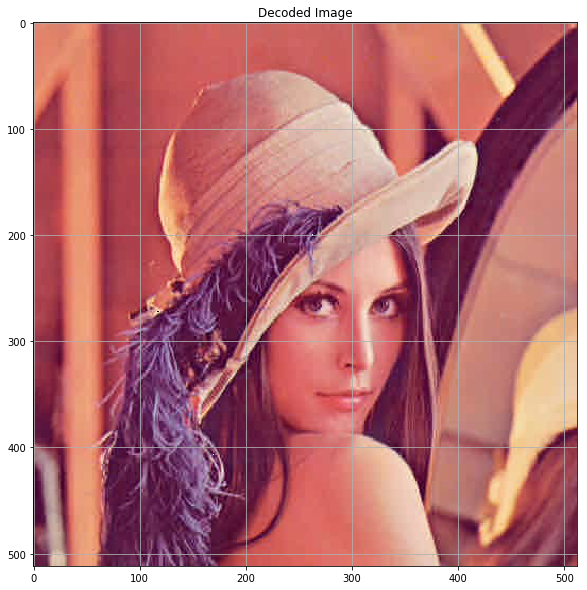


Decoding time: 1.052 s

Compression Rate: Original 786.814 kbytes | Compressed 140.936 kbytes | Ratio 0.82%

Encoding lenac.tif (107.761 kbytes) with OpenCV JPEG50

Compression Rate: Original 786.814 kbytes | Compressed 107.761 kbytes | Ratio 0.86%

SNR Original/Decoded: 1.126 db 


Gen Available RAM: 12.9 GB | Process Memory Size: 546.2 MB | Peak Usage: 542.76 MB
GPU Available RAM: 15.1 GB | Used: 0.0 GB | Util 0% | Total 15.1 GB


In [0]:
#@title Compressão de Imagem-Exemplo
Original = 'lenac.tif' #@param ['lenac.tif', 'lena.tiff']

Start = time.time()
print('\nEncoding %s (%s kbytes)' % (Original, (str(round((os.path.getsize(Notebook.RESOURCES + Original)/1000.), 3)))))
Compressed = Encoder(Notebook.RESOURCES + Original)
End = time.time()
print('\nEncoding time: {} s'.format(round(End-Start, 3)))

Start = time.time()
Output = Original.split('.')[-2] + 'compressed.dat'
print('\nDecoding %s (%s kbytes)\n' % ((Output, (str(round((os.path.getsize(Notebook.OUTPUT + Output)/1000.), 3))))))
Compressed = Decoder(Notebook.OUTPUT + Output)
End = time.time()
print('\nDecoding time: {} s'.format(round(End-Start, 3)))
print('\nCompression Rate: Original %s kbytes | Compressed %s kbytes | Ratio %s%%' % (JPEG.compression_rate(Notebook.RESOURCES + Original, Notebook.OUTPUT + Output)))

Image = cv2.imread(Notebook.RESOURCES + Original)
cv2.imwrite(Notebook.OUTPUT + 'lenaopencv.jpg', Image, [cv2.IMWRITE_PNG_COMPRESSION, 50])
print('\nEncoding %s (%s kbytes) with OpenCV JPEG50' % (Original, (str(round(os.path.getsize(Notebook.OUTPUT + 'lenaopencv.jpg')/1000., 3)))))
print('\nCompression Rate: Original %s kbytes | Compressed %s kbytes | Ratio %s%%' % (JPEG.compression_rate(Notebook.RESOURCES + Original, Notebook.OUTPUT + 'lenaopencv.jpg')))

print('\nSNR Original/Decoded: %s db ' % round(JPEG.calculateSNR(Image, Compressed.get_image()), 3))
print('\n')
Notebook.memory()

<a name="snr"></a>
# Taxa de Compressão e *SNR*
---

Ao fazer a codificação completa do algoritmo de compressão JPEG conseguimos comparar a imagem obtida com a original analisando a relação de sinal-ruído, assim como a taxa de compressão obtida. 

Verifica-se que, quando comparada com a imagem em formato TIFF (imagem-exemplo 'lenac.tif'), a imagem JPEG obtida é 82% mais pequena que a original. Por outro lado, o algoritmo implementado na biblioteca OpenCV consegue obter uma taxa de compressão de aproximadamente 86%, havendo por isso uma diferença marginal para com o algoritmo implementado no presente trabalho. 

Os valores de SNR demonstram valores inferiores (1.1dB) aos obtidos pelo algoritmo de gravação JPEG de OpenCV (na ordem dos 30dB), ressalvando-se que após a descodificação a imagem será objetivamente semelhante à original em formato TIFF, portanto com reduzida ou nula diferença na leituras entre original e compressão. Se comparamos ficheiro comprido em formato DAT ou TXT, não é possível obter SNR com o original. 

Os tempos obtidos para uma imagem inferior a 1Mb são de cerca de 1 segundo para codificação e inferior a 1 segundo para descodificação, portanto absolutamente satisfatórios.

<a name="conclusoes"></a>
# Conclusões
---
O estudo e implementação do algoritmo de compressão JPEG permitiu desenvolver uma nova perspetiva na compreensão daquilo que pode ser considerado informação útil ou informação redundante. Perceber as limitações dos sistemas sensoriais humanos, permite o desenvolvimento de algoritmos extremamente eficientes que moldam e manipulam a informação bruta (*raw*) e a transformam em informação que percetivelmente não difere do conteúdo original. A implementação destes algoritmos de compressão são os principais pilares de uma era onde a informação, em particular audiovisual, é criada a um ritmo maior do que é consumida. A explosão de conteúdos audiovisuais na *web* por exemplo, só foi possível graças à implementação de algoritmos de compressão que reduzem substancialmente a quantidade de informação redundante para um ser humano e que por isso reduz drasticamente o espaço necessário ao armazenamento destes conteúdos.

O algoritmo implementado no presente trabalho, mostra que é possível obter uma imagem que é percetivelmente muito parecida ao original. Os tempos de processamento são mínimos e permitem projetar boas *performances* em ficheiros de maior volume. Apesar do formato JPEG conter, na sua versão oficial mais informação acerca do ficheiro para garantir portabilidade entre diferentes sistemas operativos e linguagens, ainda assim a comparação de taxas de compressão obtidas nos testes realizados permite concluir que se obtêm valores muito próximos da eficiência do algoritmo da norma JPEG.